<a href="https://colab.research.google.com/github/maheshparajuli/Grovers-Algorithm/blob/master/GroversAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries and Setup


In [4]:
# Import required libraries
!pip install qiskit
!pip install qiskit-aer

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.circuit.library import ZGate, XGate
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✓ All libraries imported successfully!")
print("✓ Qiskit version:", __import__('qiskit').__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 93.4 MB/s eta 0:00:00
✓ All libraries imported successfully!
✓ Qiskit version: 2.1.0


Define the GroverOracle Class - Initialization

In [5]:
class GroverOracle:
    """
    Implementation of Grover's Algorithm with customizable oracle
    """

    def __init__(self, n_qubits, marked_items):
        """
        Initialize Grover's algorithm

        Args:
            n_qubits (int): Number of qubits (search space size = 2^n_qubits)
            marked_items (list): List of items to mark (integers)
        """
        self.n_qubits = n_qubits
        self.marked_items = marked_items
        self.search_space = 2 ** n_qubits

        # Calculate optimal number of iterations
        self.optimal_iterations = int(np.floor(np.pi/4 * np.sqrt(self.search_space)))

        print(f"Grover Oracle initialized:")
        print(f"  - Qubits: {self.n_qubits}")
        print(f"  - Search space: {self.search_space}")
        print(f"  - Marked items: {self.marked_items}")
        print(f"  - Optimal iterations: {self.optimal_iterations}")

# Test the initialization
test_grover = GroverOracle(n_qubits=3, marked_items=[5, 6])

Grover Oracle initialized:
  - Qubits: 3
  - Search space: 8
  - Marked items: [5, 6]
  - Optimal iterations: 2


Create Oracle Circuit

In [6]:
def create_oracle(self):
    """
    Create oracle circuit that flips the phase of marked items
    """
    oracle = QuantumCircuit(self.n_qubits, name='Oracle')

    for item in self.marked_items:
        # Convert item to binary and apply phase flip
        binary_rep = format(item, f'0{self.n_qubits}b')
        print(f"Marking item {item} (binary: {binary_rep})")

        # Apply X gates to qubits that should be 0 in the marked state
        for i, bit in enumerate(binary_rep):
            if bit == '0':
                oracle.x(i)

        # Apply controlled-Z gate (phase flip)
        if self.n_qubits == 1:
            oracle.z(0)
        elif self.n_qubits == 2:
            oracle.cz(0, 1)
        else:
            # Multi-controlled Z gate for n > 2
            oracle.h(self.n_qubits - 1)
            oracle.mcx(list(range(self.n_qubits - 1)), self.n_qubits - 1)
            oracle.h(self.n_qubits - 1)

        # Undo X gates
        for i, bit in enumerate(binary_rep):
            if bit == '0':
                oracle.x(i)

    return oracle

# Add method to class
GroverOracle.create_oracle = create_oracle

# Test oracle creation
oracle_circuit = test_grover.create_oracle()
print("\nOracle circuit created successfully!")
print("Oracle circuit depth:", oracle_circuit.depth())
print("\nOracle circuit diagram:")
print(oracle_circuit.draw())

Marking item 5 (binary: 101)
Marking item 6 (binary: 110)

Oracle circuit created successfully!
Oracle circuit depth: 8

Oracle circuit diagram:
                                             
q_0: ───────■───────────────────■────────────
     ┌───┐  │  ┌───┐            │            
q_1: ┤ X ├──■──┤ X ├────────────■────────────
     ├───┤┌─┴─┐├───┤┌───┐┌───┐┌─┴─┐┌───┐┌───┐
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘


Create Diffusion Operator

In [7]:
def create_diffuser(self):
    """
    Create diffusion operator (inversion about average)
    """
    diffuser = QuantumCircuit(self.n_qubits, name='Diffuser')

    # Apply Hadamard gates
    diffuser.h(range(self.n_qubits))

    # Apply X gates
    diffuser.x(range(self.n_qubits))

    # Apply multi-controlled Z gate
    if self.n_qubits == 1:
        diffuser.z(0)
    elif self.n_qubits == 2:
        diffuser.cz(0, 1)
    else:
        diffuser.h(self.n_qubits - 1)
        diffuser.mcx(list(range(self.n_qubits - 1)), self.n_qubits - 1)
        diffuser.h(self.n_qubits - 1)

    # Undo X gates
    diffuser.x(range(self.n_qubits))

    # Apply Hadamard gates
    diffuser.h(range(self.n_qubits))

    return diffuser

# Add method to class
GroverOracle.create_diffuser = create_diffuser

# Test diffuser creation
diffuser_circuit = test_grover.create_diffuser()
print("Diffuser circuit created successfully!")
print("Diffuser circuit depth:", diffuser_circuit.depth())
print("\nDiffuser circuit diagram:")
print(diffuser_circuit.draw())

Diffuser circuit created successfully!
Diffuser circuit depth: 7

Diffuser circuit diagram:
     ┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘


Create Complete Grover's Circuit

In [8]:
def create_grovers_circuit(self, iterations=None):
    """
    Create complete Grover's algorithm circuit
    """
    if iterations is None:
        iterations = self.optimal_iterations

    print(f"Creating Grover's circuit with {iterations} iterations")

    # Create quantum and classical registers
    qreg = QuantumRegister(self.n_qubits, 'q')
    creg = ClassicalRegister(self.n_qubits, 'c')
    circuit = QuantumCircuit(qreg, creg)

    # Initialize superposition
    circuit.h(range(self.n_qubits))
    circuit.barrier()

    # Create oracle and diffuser
    oracle = self.create_oracle()
    diffuser = self.create_diffuser()

    # Apply Grover iterations
    for i in range(iterations):
        circuit.append(oracle, range(self.n_qubits))
        circuit.barrier()
        circuit.append(diffuser, range(self.n_qubits))
        circuit.barrier()

    # Measure
    circuit.measure(range(self.n_qubits), range(self.n_qubits))

    return circuit

# Add method to class
GroverOracle.create_grovers_circuit = create_grovers_circuit

# Test complete circuit creation
complete_circuit = test_grover.create_grovers_circuit(iterations=1)
print(f"\nComplete Grover's circuit created!")
print(f"Circuit depth: {complete_circuit.depth()}")
print(f"Circuit width: {complete_circuit.width()}")

Creating Grover's circuit with 1 iterations
Marking item 5 (binary: 101)
Marking item 6 (binary: 110)

Complete Grover's circuit created!
Circuit depth: 4
Circuit width: 6


Simulation and Analysis Methods

In [9]:
def simulate(self, circuit, shots=1024):
    """
    Simulate the quantum circuit
    """
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=shots).result()
    counts = result.get_counts(compiled_circuit)
    return counts

def analyze_results(self, counts):
    """
    Analyze simulation results
    """
    total_shots = sum(counts.values())

    print(f"Search space size: {self.search_space}")
    print(f"Marked items: {self.marked_items}")
    print(f"Optimal iterations: {self.optimal_iterations}")
    print(f"Total shots: {total_shots}")
    print("\nResults:")
    print("-" * 50)

    # Sort results by probability
    sorted_results = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    for state, count in sorted_results:
        decimal_value = int(state, 2)
        probability = count / total_shots
        is_marked = "✓ MARKED" if decimal_value in self.marked_items else ""
        print(f"State |{state}⟩ (decimal {decimal_value:2d}): "
              f"{count:4d} counts ({probability:.3f}) {is_marked}")

    # Calculate success probability
    success_count = sum(count for state, count in counts.items()
                      if int(state, 2) in self.marked_items)
    success_probability = success_count / total_shots
    print(f"\nSuccess probability: {success_probability:.3f}")

    return success_probability, counts

# Add methods to class
GroverOracle.simulate = simulate
GroverOracle.analyze_results = analyze_results

print("✓ Simulation and analysis methods added to GroverOracle class")

✓ Simulation and analysis methods added to GroverOracle class


Simple 2-Qubit Example

In [10]:
print("="*60)
print("EXAMPLE 1: 2-QUBIT GROVER'S ALGORITHM")
print("="*60)

# Create 2-qubit Grover oracle searching for item 3 (binary: 11)
grover_2q = GroverOracle(n_qubits=2, marked_items=[3])

# Create and simulate circuit
circuit_2q = grover_2q.create_grovers_circuit()
counts_2q = grover_2q.simulate(circuit_2q, shots=2048)

# Analyze results
success_prob_2q, _ = grover_2q.analyze_results(counts_2q)

# Visualize circuit
print("\nCircuit diagram:")
print(circuit_2q.draw())

EXAMPLE 1: 2-QUBIT GROVER'S ALGORITHM
Grover Oracle initialized:
  - Qubits: 2
  - Search space: 4
  - Marked items: [3]
  - Optimal iterations: 1
Creating Grover's circuit with 1 iterations
Marking item 3 (binary: 11)
Search space size: 4
Marked items: [3]
Optimal iterations: 1
Total shots: 2048

Results:
--------------------------------------------------
State |11⟩ (decimal  3): 2048 counts (1.000) ✓ MARKED

Success probability: 1.000

Circuit diagram:
     ┌───┐ ░ ┌─────────┐ ░ ┌───────────┐ ░ ┌─┐   
q_0: ┤ H ├─░─┤0        ├─░─┤0          ├─░─┤M├───
     ├───┤ ░ │  Oracle │ ░ │  Diffuser │ ░ └╥┘┌─┐
q_1: ┤ H ├─░─┤1        ├─░─┤1          ├─░──╫─┤M├
     └───┘ ░ └─────────┘ ░ └───────────┘ ░  ║ └╥┘
c: 2/═══════════════════════════════════════╩══╩═
                                            0  1 


Visualize 2-Qubit Results

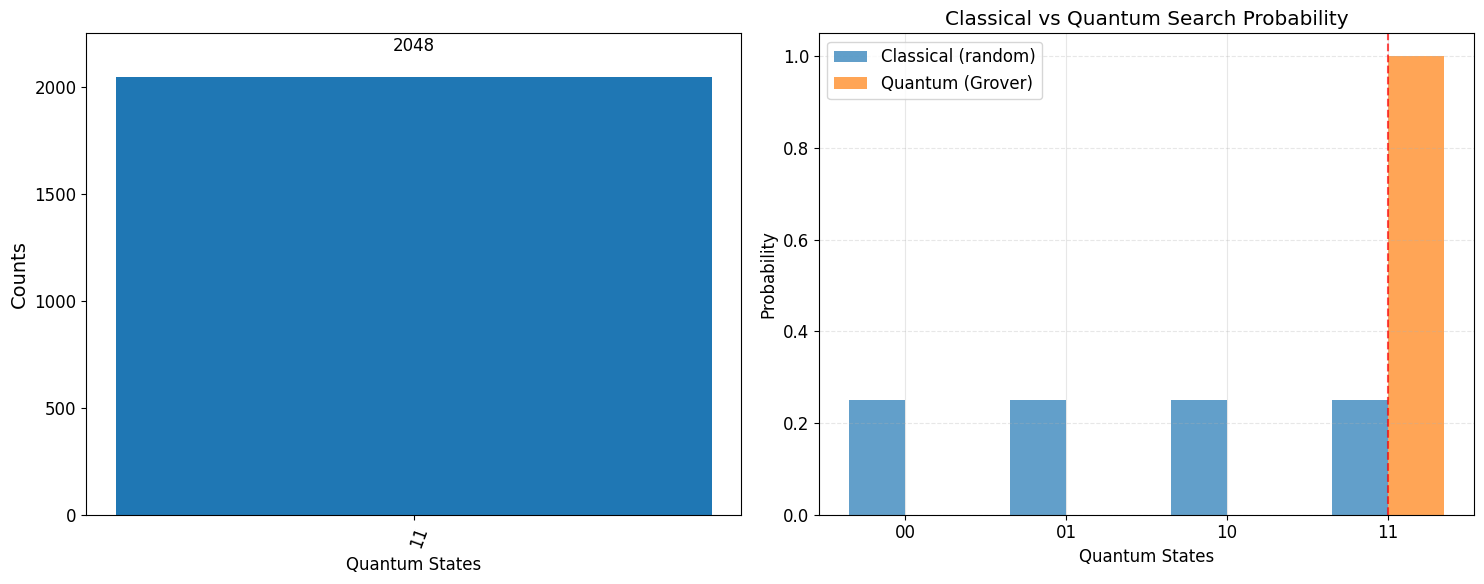

Classical random search success probability: 0.250
Grover's algorithm success probability: 1.000
Improvement factor: 4.00x


In [11]:
# Create visualization for 2-qubit example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram
plot_histogram(counts_2q, ax=ax1, title="2-Qubit Grover's Algorithm Results")
ax1.set_xlabel('Quantum States')
ax1.set_ylabel('Counts')

# Create probability comparison
states = ['00', '01', '10', '11']
measured_probs = [counts_2q.get(state, 0)/2048 for state in states]
classical_prob = [0.25] * 4  # Random guess probability

x = np.arange(len(states))
width = 0.35

ax2.bar(x - width/2, classical_prob, width, label='Classical (random)', alpha=0.7)
ax2.bar(x + width/2, measured_probs, width, label='Quantum (Grover)', alpha=0.7)

ax2.set_xlabel('Quantum States')
ax2.set_ylabel('Probability')
ax2.set_title('Classical vs Quantum Search Probability')
ax2.set_xticks(x)
ax2.set_xticklabels(states)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Highlight marked state
ax2.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Marked item')

plt.tight_layout()
plt.show()

print(f"Classical random search success probability: 0.250")
print(f"Grover's algorithm success probability: {success_prob_2q:.3f}")
print(f"Improvement factor: {success_prob_2q/0.25:.2f}x")